# IBM Applied Data Science Capstone Project
# The competition of restaurants by district in Bangkok
Kitithat Pansang  
March 31, 2021


## 1. Introduction
### 1.1 Background
   Thailand is a paradise for tourism that is popular with people from all over the world. One of the key factors is the diversity of food and the culture of eating. Thai cooking places emphasis on lightly prepared dishes with strong aromatic components and a spicy edge. And there are also many nationalities of food in Thailand such as Japan, Korea, Europe, Asia, the Middle East.   
### 1.2 Business Problem
   Longyang is a name of Thai restaurant that is mean “Have you tried?”. It is a restaurant that sells Thai and Chinese food. At present, the second generation of heirs is inheriting the business. The owners are deciding to expand their food sales category between Japan and Traditional Thai food, which will open next to the original store at xxxxxxx.  She is working on various factors that help make decisions, and one of them is a competition in the neighborhood. In additional, it is also a good idea to look for another location that will open new restaurants in the future in the new area.
To address this business problem, research will be done using data science methodology and machine learning techniques such as clustering to find the answers.

#### Import libraties

In [167]:
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup

import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import getpass
import seaborn as sns

---

## 2. Data acquisition and cleaning
### 2.1 Data sources
•	The 5o Districts and 180 Subdistricts of Bangkok which can be obtained from Wiki page “Khwaeng”.
•	Geospatial of each location can use GeoPy package to get latitude and longitude base on subdistricts name.
•	The Foursquare API was used to add venue data for the neighborhoods such as number of restaurants, category, etc.



### 1.2 Data cleaning
The 5o Districts and 180 Subdistricts of Bangkok table included name of districts and subdistricts that use to get Geospatial of each location and combine into one table. But some names may be specific, which cannot be obtained from GeoPy package. Therefore, need to explore the deficiency and find another source such as google map.
The data that obtained form Foursquare API will be in the form of JSON file and in order to be able to work, it must be adjusted to homogeneous dataset in the form of a table which will later on be used for the k-means clustering technique.

## 3. Methodology
### 3.1 Data loading
First, Scrapping from the Wikipedia that contains Districts and Subdistricts of Bangkok. The table use attribute “rowspan” to merge the table like pivot table for easy to explore.


In [2]:
url = 'https://en.wikipedia.org/wiki/Khwaeng'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')
table = soup.find('tbody').find_all('td')

bkk_districts = {'Subdistrict':[],'Subdistrict_in_Thai':[] ,'District':[], 'District_in_Thai':[], 'Latitude':[], 'Longitude':[]}

count_district = 0
count_subdistrict = 0
for ind,value in enumerate(table[6:]):
    try:
        rowspan = int(value.attrs['rowspan'])
        count_district += 1
        count_subdistrict = 0
        if count_district == 3:
            district = table[ind-1+6].text.strip()
            district_in_thai = table[ind+6].text.strip()
    except:
        count_district = 0
        count_subdistrict += 1
        if count_subdistrict%4 == 3:
            bkk_districts['District'].append(district)
            bkk_districts['District_in_Thai'].append(district_in_thai)
            bkk_districts['Subdistrict'].append(table[ind-1+6].text.strip())
            bkk_districts['Subdistrict_in_Thai'].append(table[ind+6].text.strip())
            bkk_districts['Latitude'].append(None)
            bkk_districts['Longitude'].append(None)
            

bkk_district_data = pd.DataFrame(bkk_districts)
bkk_district_data

,Subdistrict,Subdistrict_in_Thai,District,District_in_Thai,Latitude,Longitude
0,Phra Borom Maha Ratchawang,พระบรมมหาราชวัง,Phra Nakhon,พระนคร,None,None
1,Wang Burapha Phirom,วังบูรพาภิรมย์,Phra Nakhon,พระนคร,None,None
2,Wat Ratchabophit,วัดราชบพิธ,Phra Nakhon,พระนคร,None,None
3,Samran Rat,สำราญราษฎร์,Phra Nakhon,พระนคร,None,None
4,San Chaopho Suea,ศาลเจ้าพ่อเสือ,Phra Nakhon,พระนคร,None,None
...,...,...,...,...,...,...
175,Thung Khru,ทุ่งครุ,Thung Khru,ทุ่งครุ,None,None
176,Bang Bon Nuea,บางบอนเหนือ,Bang Bon,บางบอน,None,None
177,Bang Bon Tai,บางบอนใต้,Bang Bon,บางบอน,None,None
178,Khlong Bang Phran,คลองบางพราน,Bang Bon,บางบอน,None,None


#### Next, use name of subdistricts for search latitude and longitude by using GeoPy python package and check whether the information has been completed or not.

In [3]:
for ind, subdistrict in enumerate(bkk_district_data['Subdistrict']):
    address = subdistrict + ', Bangkok'
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude

        bkk_district_data.loc[ind]['Latitude'] = latitude
        bkk_district_data.loc[ind]['Longitude'] = longitude
        print(f'The geograpical coordinate of {address} are {latitude}, {longitude}.')
    except:
        print(f'***The geograpical coordinate of {address} are not found.***')
        continue

The geograpical coordinate of Phra Borom Maha Ratchawang, Bangkok are 13.7499943, 100.4917502.
The geograpical coordinate of Wang Burapha Phirom, Bangkok are 13.7456684, 100.5018588.
The geograpical coordinate of Wat Ratchabophit, Bangkok are 13.7491606, 100.4972327.
The geograpical coordinate of Samran Rat, Bangkok are 13.7521515, 100.5044746.
The geograpical coordinate of San Chaopho Suea, Bangkok are 12.5699511, 99.9554748.
The geograpical coordinate of Sao Chingcha, Bangkok are 13.7518891, 100.5012654.
The geograpical coordinate of Bowon Niwet, Bangkok are 13.7598162, 100.5007356.
The geograpical coordinate of Talat Yot, Bangkok are 13.7603321, 100.4978979.
The geograpical coordinate of Chana Songkhram, Bangkok are 13.7608948, 100.4951566.
The geograpical coordinate of Ban Phan Thom, Bangkok are 13.7622495, 100.5016047.
The geograpical coordinate of Bang Khun Phrom, Bangkok are 13.7670199, 100.5016237.
The geograpical coordinate of Wat Sam Phraya, Bangkok are 13.7658186, 100.499078

The geograpical coordinate of Bang Bamru, Bangkok are 13.7920528, 100.4774978.
The geograpical coordinate of Bang Yi Khan, Bangkok are 13.7718157, 100.4890358.
The geograpical coordinate of Din Daeng, Bangkok are 13.7603529, 100.5550665.
The geograpical coordinate of Ratchadaphisek, Bangkok are 13.7858098, 100.5735576.
The geograpical coordinate of Khlong Kum, Bangkok are 13.7853201, 100.6686634.
The geograpical coordinate of Nawamin, Bangkok are 13.8019807, 100.6479299.
The geograpical coordinate of Nuan Chan, Bangkok are 13.8348792, 100.6377134.
The geograpical coordinate of Thung Wat Don, Bangkok are 13.712446, 100.5214426.
The geograpical coordinate of Yan Nawa, Bangkok are 13.6797229, 100.5435276.
The geograpical coordinate of Thung Maha Mek, Bangkok are 13.716717, 100.5401214.
The geograpical coordinate of Bang Sue, Bangkok are 13.803287, 100.5385126.
The geograpical coordinate of Wong Sawang, Bangkok are 13.8231158, 100.5227053.
The geograpical coordinate of Lat Yao, Bangkok are

#### Found that the data had not been completed in all 4 subdistricts. Therefore need to find more from Google map.

In [4]:
bkk_district_data[bkk_district_data['Latitude'].isna()]

,Subdistrict,Subdistrict_in_Thai,District,District_in_Thai,Latitude,Longitude
13,Wachiraphayaban,วชิรพยาบาล,Dusit,ดุสิต,None,None
117,Chomphon,จอมพล,Chatuchak,จตุจักร,None,None
137,Sanambin,สนามบิน,Don Mueang,ดอนเมือง,None,None
163,Khlong Chaokhun Sing,คลองเจ้าคุณสิงห์,Wang Thonglang,วังทองหลาง,None,None


In [5]:
bkk_district_data.loc[13]['Latitude'] = 13.778491800083811
bkk_district_data.loc[13]['Longitude'] = 100.50562862722236

bkk_district_data.loc[117]['Latitude'] = 13.808610878301186
bkk_district_data.loc[117]['Longitude'] = 100.56550935617311

bkk_district_data.loc[137]['Latitude'] = 13.916337489929715
bkk_district_data.loc[137]['Longitude'] = 100.61011521152705

bkk_district_data.loc[163]['Latitude'] = 13.788698528860444
bkk_district_data.loc[163]['Longitude'] = 100.61964375969697

#### Check data again thai data is completed

In [6]:
bkk_district_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Subdistrict          180 non-null    object
 1   Subdistrict_in_Thai  180 non-null    object
 2   District             180 non-null    object
 3   District_in_Thai     180 non-null    object
 4   Latitude             180 non-null    object
 5   Longitude            180 non-null    object
dtypes: object(6)
memory usage: 8.6+ KB


#### Exploration: Display all location by using folium python package in map to see the distribution of the area and check the data set is correct by seeing that it covers all over Bangkok.

In [7]:
address = 'Bangkok'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 13.7544238, 100.4930399.


In [8]:
# Toronto latitude and longitude if geopy.geocoders has bad gateway error
# latitude = 43.6534817
# longitude = -79.3839347

# create map of Toronto using latitude and longitude values
map_bkk = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, subdistrict, district in zip(bkk_district_data['Latitude'],
                                           bkk_district_data['Longitude'], 
                                           bkk_district_data['Subdistrict'], 
                                           bkk_district_data['District']):
    label = '{}, {}'.format(subdistrict, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bkk)  
    
map_bkk

#### Define Foursquare Credentials and Version

In [37]:
CLIENT_ID = 'FJ2FIIL3Q1KMNH2KZ0RGOTZ4GGBXS0WGOLBGQRETYSOOLWOX'
CLIENT_SECRET = '2EHTHLA44RDD3VECVWEUADJEFES5KWWV5MBMT0PUBIURWM4E'

In [11]:
# enter your Foursquare ID
CLIENT_ID = getpass.getpass()

········


In [12]:
# enter your Foursquare Secret
CLIENT_SECRET = getpass.getpass()

········


In [38]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET[:10] + 'X'*(len(CLIENT_SECRET)-10))

Your credentails:
CLIENT_ID: FJ2FIIL3Q1KMNH2KZ0RGOTZ4GGBXS0WGOLBGQRETYSOOLWOX
CLIENT_SECRET:2EHTHLA44RXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


#### The FourSquare API was called for each Seattle neighborhood zip code. Our FourSquare request was limited to just the top 100 most common venues per request because that is more than sufficient for our analysis, and to avoid cap on daily request size. Our FourSquare request was also limited to 800 meters and set query category to “Food”.

In [42]:
# function that get the venues that are in neighborhood within a radius of 500 meters in default
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
        # query food category
        categoryId = '4d4b7105d754a06374d81259'
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)

        # make the GET request
#         print(f'url: {url}')
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
# get downtown's nearby venues in Toronto.
downtown_venues = getNearbyVenues(names=bkk_district_data['Subdistrict'],
                                  latitudes=bkk_district_data['Latitude'],
                                  longitudes=bkk_district_data['Longitude']
                                 )

# check the size of the resulting dataframe and preview
print(f'Dataframe size {downtown_venues.shape}')
downtown_venues.head()

Dataframe size (6674, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Phra Borom Maha Ratchawang,13.749994,100.49175,Ama Art & Eatery,13.746449,100.490782,Thai Restaurant
1,Phra Borom Maha Ratchawang,13.749994,100.49175,Home Café Tha Tien (โฮม คาเฟ่ ท่าเตียน),13.745696,100.491260,Café
2,Phra Borom Maha Ratchawang,13.749994,100.49175,A Pink Rabbit + Bob,13.745032,100.492030,Café
3,Phra Borom Maha Ratchawang,13.749994,100.49175,Supanniga Eating Room x Roots Coffee (ห้องทานข...,13.744162,100.491700,Thai Restaurant
4,Phra Borom Maha Ratchawang,13.749994,100.49175,Tonkin - Annam (ตงกิง - อันนัม),13.745103,100.491297,Vietnamese Restaurant


In [45]:
# check how many venues were returned for each neighborhood
downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Anusawari,35,35,35,35,35,35
Arun Ammarin,46,46,46,46,46,46
Ban Bat,76,76,76,76,76,76
Ban Chang Lo,76,76,76,76,76,76
Ban Phan Thom,93,93,93,93,93,93
...,...,...,...,...,...,...
Wat Sommanat,65,65,65,65,65,65
Wat Tha Phra,14,14,14,14,14,14
Wat Thep Sirin,51,51,51,51,51,51


In [78]:
bkk_venues = downtown_venues[:].copy()

#### Check unique venue categories

In [50]:
print(f'Number of unique categories: {len(downtown_venues["Venue Category"].unique())}')
print(sorted(downtown_venues["Venue Category"].unique()))

Number of unique categories: 88
['African Restaurant', 'American Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bistro', 'Breakfast Spot', 'Buffet', 'Burger Joint', 'Cafeteria', 'Café', 'Cajun / Creole Restaurant', 'Cantonese Restaurant', 'Chinese Restaurant', 'Comfort Food Restaurant', 'Creperie', 'Deli / Bodega', 'Dim Sum Restaurant', 'Diner', 'Donburi Restaurant', 'Donut Shop', 'Dumpling Restaurant', 'Fast Food Restaurant', 'Fish & Chips Shop', 'Food', 'Food Court', 'Food Stand', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'Gastropub', 'German Restaurant', 'Greek Restaurant', 'Hainan Restaurant', 'Halal Restaurant', 'Hotpot Restaurant', 'Indian Restaurant', 'Irish Pub', 'Israeli Restaurant', 'Italian Restaurant', 'Japanese Curry Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European

#### Group same category that same nationality

In [79]:
group_catagory = { 'American': ['American Restaurant','New American Restaurant'],
                 'Bakery': ['Bagel Shop','Bakery','Donut Shop'],
                 'Cafe': ['Cafeteria','Café','Creperie','Pet Café'],
                 'Chinese': ['Cantonese Restaurant','Chinese Restaurant','Dim Sum Restaurant','Dumpling Restaurant',
                             'Shanghai Restaurant','Taiwanese Restaurant'],
                 'Japan': ['Donburi Restaurant','Yoshoku Restaurant','Yakitori Restaurant','Udon Restaurant',
                           'Tonkatsu Restaurant','Japanese Curry Restaurant','Japanese Restaurant','Ramen Restaurant',
                           'Sushi Restaurant'],
                 'Bar': ['Gastropub','Irish Pub','Bistro'],
                 'Thai': ['Som Tum Restaurant','Thai Restaurant'],
                 'Indian': ['Indian Restaurant' ,'South Indian Restaurant']
                }

In [140]:
bkk_venues['Grouped_Venue_Category'] = bkk_venues['Venue Category']

for ind1,old in enumerate(bkk_venues['Venue Category']):
    for ind2,group in enumerate(group_catagory.values()):
        for element in group:
            if old == element:
                bkk_venues.loc[ind1,'Grouped_Venue_Category'] = list(group_catagory.keys())[ind2]
                
bkk_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Grouped_Vanue_Category,Grouped_Venue_Category
0,Phra Borom Maha Ratchawang,13.749994,100.491750,Ama Art & Eatery,13.746449,100.490782,Thai Restaurant,Thai Restaurant,Thai
1,Phra Borom Maha Ratchawang,13.749994,100.491750,Home Café Tha Tien (โฮม คาเฟ่ ท่าเตียน),13.745696,100.491260,Café,Café,Cafe
2,Phra Borom Maha Ratchawang,13.749994,100.491750,A Pink Rabbit + Bob,13.745032,100.492030,Café,Café,Cafe
3,Phra Borom Maha Ratchawang,13.749994,100.491750,Supanniga Eating Room x Roots Coffee (ห้องทานข...,13.744162,100.491700,Thai Restaurant,Thai Restaurant,Thai
4,Phra Borom Maha Ratchawang,13.749994,100.491750,Tonkin - Annam (ตงกิง - อันนัม),13.745103,100.491297,Vietnamese Restaurant,Vietnamese Restaurant,Vietnamese Restaurant
...,...,...,...,...,...,...,...,...,...
6669,Khlong Bang Bon,13.670695,100.427377,Black Jack Caffe,13.664153,100.428033,Restaurant,Restaurant,Restaurant
6670,Khlong Bang Bon,13.670695,100.427377,ต้าหลง,13.664133,100.428174,Hotpot Restaurant,Hotpot Restaurant,Hotpot Restaurant
6671,Khlong Bang Bon,13.670695,100.427377,ร้านป้าเล็กมหาชัย,13.664032,100.427762,Restaurant,Restaurant,Restaurant
6672,Khlong Bang Bon,13.670695,100.427377,หมูตุ๋น เนื้อตุ๋น ยาจีน,13.669986,100.420446,Noodle House,Noodle House,Noodle House


In [141]:
print(f'Number of unique categories: {len(bkk_venues["Grouped_Venue_Category"].unique())}')

Number of unique categories: 65


#### Analyze Each Neighborhood

In [144]:
# one hot encoding
bkk_onehot = pd.get_dummies(bkk_venues[['Grouped_Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bkk_onehot['Neighborhood'] = bkk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

# check the size of the resulting dataframe and preview
print(f'Dataframe size {downtown_onehot.shape}')
bkk_onehot.head()

Dataframe size (6674, 66)


,Neighborhood,African Restaurant,American,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Buffet,...,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Phra Borom Maha Ratchawang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Phra Borom Maha Ratchawang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Phra Borom Maha Ratchawang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Phra Borom Maha Ratchawang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Phra Borom Maha Ratchawang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [148]:
bkk_grouped = bkk_onehot.groupby('Neighborhood').mean().reset_index()

bkk_grouped

,Neighborhood,African Restaurant,American,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Buffet,...,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Anusawari,0.0,0.000000,0.057143,0.0,0.028571,0.057143,0.000000,0.000000,0.000000,...,0.0,0.028571,0.0,0.0,0.0,0.114286,0.0,0.000000,0.028571,0.000000
1,Arun Ammarin,0.0,0.000000,0.108696,0.0,0.021739,0.000000,0.000000,0.000000,0.000000,...,0.0,0.021739,0.0,0.0,0.0,0.217391,0.0,0.000000,0.000000,0.000000
2,Ban Bat,0.0,0.013158,0.157895,0.0,0.000000,0.026316,0.000000,0.013158,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.157895,0.0,0.000000,0.000000,0.000000
3,Ban Chang Lo,0.0,0.000000,0.052632,0.0,0.000000,0.039474,0.000000,0.000000,0.000000,...,0.0,0.052632,0.0,0.0,0.0,0.355263,0.0,0.000000,0.013158,0.013158
4,Ban Phan Thom,0.0,0.000000,0.096774,0.0,0.010753,0.043011,0.010753,0.010753,0.000000,...,0.0,0.010753,0.0,0.0,0.0,0.236559,0.0,0.053763,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Wat Sommanat,0.0,0.015385,0.061538,0.0,0.015385,0.015385,0.000000,0.015385,0.000000,...,0.0,0.046154,0.0,0.0,0.0,0.246154,0.0,0.000000,0.000000,0.000000
171,Wat Tha Phra,0.0,0.000000,0.142857,0.0,0.071429,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.000000
172,Wat Thep Sirin,0.0,0.000000,0.156863,0.0,0.019608,0.000000,0.000000,0.000000,0.019608,...,0.0,0.000000,0.0,0.0,0.0,0.058824,0.0,0.019608,0.000000,0.000000
173,Wong Sawang,0.0,0.000000,0.041667,0.0,0.041667,0.125000,0.000000,0.000000,0.000000,...,0.0,0.083333,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,0.000000


In [182]:
bkk_grouped_thai = bkk_grouped.sort_values(by='Thai', ascending=False)
bkk_grouped_thai

,Neighborhood,African Restaurant,American,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Buffet,...,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
82,Lam Phak Chi,0.0,0.0,0.200000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0
69,Khlong Song Ton Nun,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0
134,Si Kan,0.0,0.0,0.040000,0.0,0.040000,0.000000,0.0,0.0,0.0,...,0.0,0.040000,0.0,0.0,0.0,0.480000,0.0,0.0,0.0,0.0
54,Dusit,0.0,0.0,0.000000,0.0,0.000000,0.090909,0.0,0.0,0.0,...,0.0,0.090909,0.0,0.0,0.0,0.454545,0.0,0.0,0.0,0.0
86,Lat Yao,0.0,0.0,0.074074,0.0,0.000000,0.037037,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.444444,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Thap Yao,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
81,Lak Song,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
124,Samae Dam,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
109,Prawet,0.0,0.0,0.000000,0.0,0.111111,0.111111,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


No handles with labels found to put in legend.


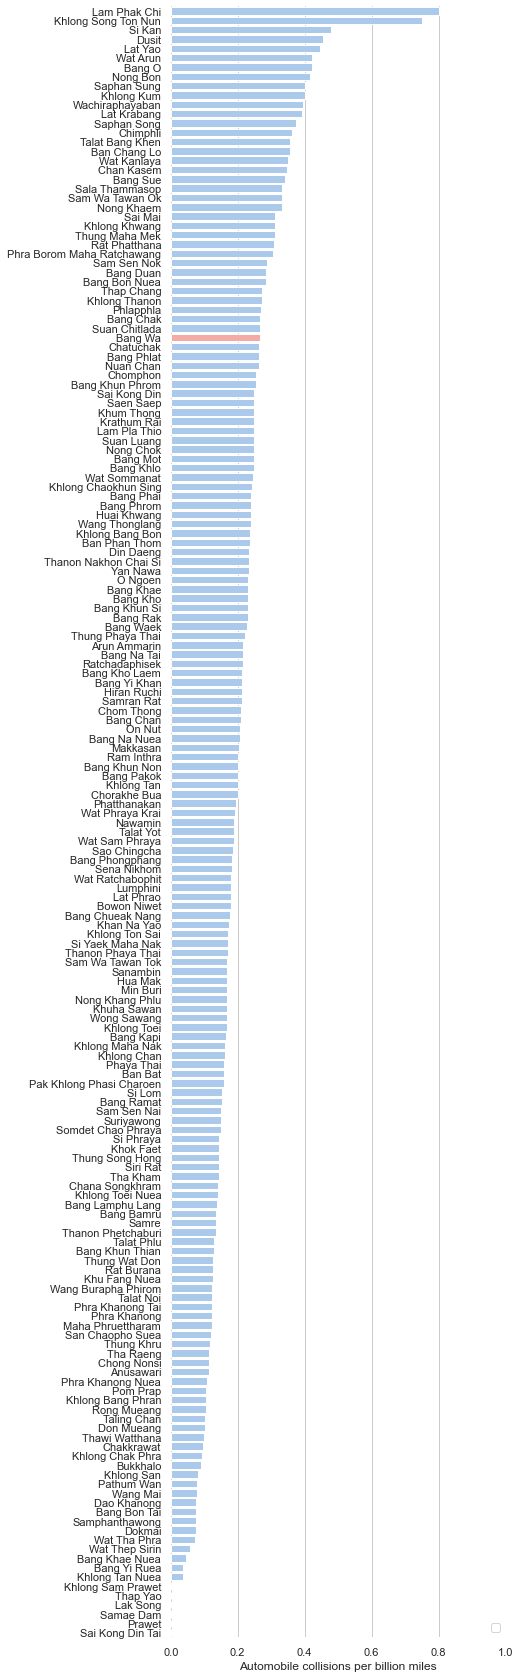

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 30))

# Load the example car crash dataset
# crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x='Thai', 
            y='Neighborhood', 
            data=bkk_grouped_thai,
            palette=["b" if x!='Bang Wa' else 'r' for x in bkk_grouped_thai['Neighborhood']])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [186]:
bkk_grouped_japan = bkk_grouped.sort_values(by='Japan', ascending=False)
bkk_grouped_japan

,Neighborhood,African Restaurant,American,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Breakfast Spot,Buffet,...,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
154,Thap Yao,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
116,Sai Kong Din,0.0,0.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.000000
141,Suan Luang,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.000000
135,Si Lom,0.0,0.010989,0.000000,0.0,0.043956,0.021978,0.000000,0.032967,0.021978,...,0.0,0.010989,0.0,0.0,0.0,0.153846,0.0,0.010989,0.010989,0.000000
14,Bang Khae Nuea,0.0,0.000000,0.023256,0.0,0.069767,0.093023,0.000000,0.000000,0.000000,...,0.0,0.116279,0.0,0.0,0.0,0.046512,0.0,0.000000,0.023256,0.023256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Sam Wa Tawan Tok,0.0,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,0.000000
122,Sam Wa Tawan Ok,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.000000,0.000000,0.000000
26,Bang O,0.0,0.000000,0.052632,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.052632,0.0,0.0,0.0,0.421053,0.0,0.000000,0.000000,0.000000
78,Khuha Sawan,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,0.000000


No handles with labels found to put in legend.


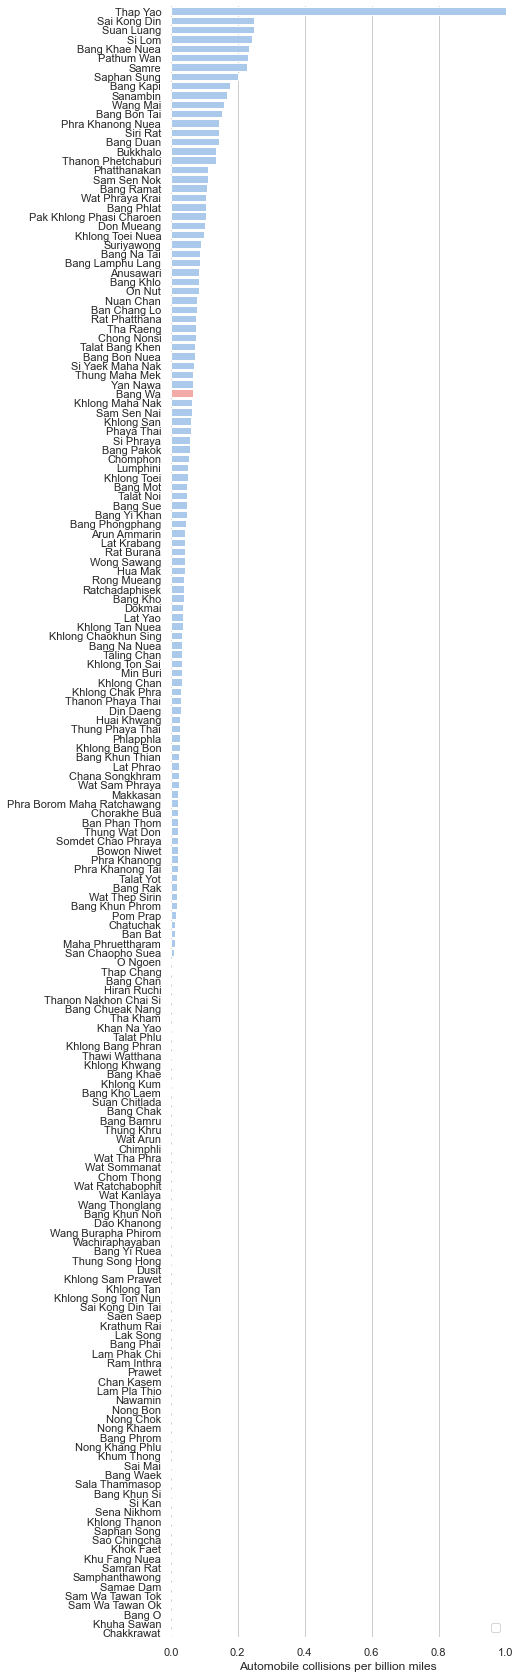

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 30))

# Load the example car crash dataset
# crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x='Japan', 
            y='Neighborhood', 
            data=bkk_grouped_japan,
            palette=["b" if x!='Bang Wa' else 'r' for x in bkk_grouped_japan['Neighborhood']])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [192]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [227]:
# create the new dataframe and display the top venues for each neighborhood
num_top_venues = 10 # set number of top venues for each neighborhood to collect

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bkk_grouped['Neighborhood']

for ind in np.arange(bkk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bkk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anusawari,Noodle House,Fast Food Restaurant,Thai,Japan,Hotpot Restaurant,Food Court,Asian Restaurant,Bakery,Steakhouse,Restaurant
1,Arun Ammarin,Noodle House,Thai,Asian Restaurant,Chinese,Japan,Food Truck,Shabu-Shabu Restaurant,Hotpot Restaurant,Seafood Restaurant,Pizza Place
2,Ban Bat,Noodle House,Asian Restaurant,Thai,Chinese,Fast Food Restaurant,Seafood Restaurant,Bakery,Cafe,Japan,American
3,Ban Chang Lo,Thai,Noodle House,Cafe,Japan,Asian Restaurant,Steakhouse,Bakery,Fried Chicken Joint,Food Court,Vietnamese Restaurant
4,Ban Phan Thom,Thai,Noodle House,Cafe,Asian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese,Italian Restaurant,Indian,Israeli Restaurant


In [228]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'] == 'Bang Wa']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Bang Wa,Thai,Asian Restaurant,Noodle House,Chinese,Steakhouse,Japan,Bakery,Seafood Restaurant,Middle Eastern Restaurant,Modern European Restaurant


In [230]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename({"Neighborhood": "Subdistrict"}, axis=1)
neighborhoods_venues_sorted

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anusawari,Noodle House,Fast Food Restaurant,Thai,Japan,Hotpot Restaurant,Food Court,Asian Restaurant,Bakery,Steakhouse,Restaurant
1,Arun Ammarin,Noodle House,Thai,Asian Restaurant,Chinese,Japan,Food Truck,Shabu-Shabu Restaurant,Hotpot Restaurant,Seafood Restaurant,Pizza Place
2,Ban Bat,Noodle House,Asian Restaurant,Thai,Chinese,Fast Food Restaurant,Seafood Restaurant,Bakery,Cafe,Japan,American
3,Ban Chang Lo,Thai,Noodle House,Cafe,Japan,Asian Restaurant,Steakhouse,Bakery,Fried Chicken Joint,Food Court,Vietnamese Restaurant
4,Ban Phan Thom,Thai,Noodle House,Cafe,Asian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Chinese,Italian Restaurant,Indian,Israeli Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
170,Wat Sommanat,Thai,Cafe,Noodle House,Chinese,Asian Restaurant,Steakhouse,Snack Place,BBQ Joint,Bakery,Hainan Restaurant
171,Wat Tha Phra,Food Truck,Asian Restaurant,Noodle House,Hotpot Restaurant,Food,BBQ Joint,Soup Place,Thai,Pizza Place,Chinese
172,Wat Thep Sirin,Noodle House,Chinese,Asian Restaurant,Thai,Cafe,Satay Restaurant,Hotpot Restaurant,Snack Place,Soup Place,Food Court
173,Wong Sawang,Thai,Bakery,Food Court,Noodle House,Cafe,Steakhouse,Diner,Japan,Asian Restaurant,Food Truck


### Cluster Neighborhoods

In [245]:
# Run k-means to cluster the neighborhood into 5 clusters
kclusters = 5  # set number of clusters

bkk_grouped_clustering = bkk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 3, 2, 1, 1, 0, 1, 1])

In [275]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = bkk_district_data

# merge downtown_grouped with downtown_toronto to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Subdistrict'), on='Subdistrict')

downtown_merged.head() # check the last columns!

,Subdistrict,Subdistrict_in_Thai,District,District_in_Thai,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phra Borom Maha Ratchawang,พระบรมมหาราชวัง,Phra Nakhon,พระนคร,13.749994,100.49175,4.0,Thai,Cafe,Noodle House,Asian Restaurant,Chinese,Japan,Soup Place,Restaurant,Diner,Vietnamese Restaurant
1,Wang Burapha Phirom,วังบูรพาภิรมย์,Phra Nakhon,พระนคร,13.745668,100.501859,3.0,Noodle House,Chinese,Cafe,Thai,Asian Restaurant,Fast Food Restaurant,Seafood Restaurant,Breakfast Spot,Indian,Snack Place
2,Wat Ratchabophit,วัดราชบพิธ,Phra Nakhon,พระนคร,13.749161,100.497233,4.0,Cafe,Thai,Noodle House,Asian Restaurant,Chinese,Fast Food Restaurant,Breakfast Spot,Restaurant,Snack Place,Bakery
3,Samran Rat,สำราญราษฎร์,Phra Nakhon,พระนคร,13.752152,100.504475,3.0,Noodle House,Thai,Asian Restaurant,Chinese,Cafe,Fast Food Restaurant,BBQ Joint,Bakery,Snack Place,Hainan Restaurant
4,San Chaopho Suea,ศาลเจ้าพ่อเสือ,Phra Nakhon,พระนคร,12.569951,99.955475,1.0,Seafood Restaurant,Thai,Noodle House,Italian Restaurant,Cafe,Asian Restaurant,Fast Food Restaurant,Pizza Place,Bakery,American


In [281]:
downtown_merged = downtown_merged.dropna()
downtown_merged['Cluster Labels'] = downtown_merged['Cluster Labels'].astype(int)

In [283]:
# visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], 
                                  downtown_merged['Longitude'], 
                                  downtown_merged['Subdistrict'], 
                                  downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters